# Colab

In [1]:
# !git clone -b tree-ranking https://github.com/KernelA/education-recsys.git

In [2]:
# %cd /content/education-recsys/

In [3]:
# !pip install --no-cache-dir -r ./requirements.txt  kaggle

In [4]:
# %load_ext dotenv
# %dotenv

In [5]:
# !kaggle datasets download -d sharthz23/mts-library -p ./data --unzip 

In [6]:
import os

In [7]:
is_colab = False

In [8]:
if is_colab:
    remote_dir = "/content/drive"
else:
    remote_dir = os.getcwd()

In [9]:
if is_colab:
    from google.colab import drive
    drive.mount(remote_dir)

In [10]:
if is_colab:
    out_exp_dir = os.path.join(remote_dir, "MyDrive/EducationRecSys/tree-ranking")
else:
    out_exp_dir = os.path.join(remote_dir, "catboost-dir")

In [11]:
if is_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

# Основной код

In [12]:
import os
import pathlib
from datetime import timedelta

import seaborn as sns
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from implicit.als import AlternatingLeastSquares
from catboost import Pool, CatBoostClassifier, FeaturesData
import shap

In [13]:
sns.set_style("darkgrid")

In [14]:
%load_ext autoreload
%autoreload 2

from recs_utils.metrics import compute_metrics, model_cross_validate, mean_average_prec, join_true_pred_and_preprocess, precision_at_k
from recs_utils.load_data import MTSDataset, MovieLens100K
from recs_utils.split import TimeRangeSplit
from recs_utils.implicit_model import ImplicitRecommender
from recs_utils.ranking import convert_to_features_data

In [15]:
data_dir = pathlib.Path("./data/mts/dump")

In [16]:
df = pl.read_parquet(data_dir / "interactions.parquet")
df_users = pl.read_parquet(data_dir / "users.parquet")
df_items = MTSDataset.select_genres(pl.read_parquet(data_dir / "items.parquet"), 0.98)

In [17]:
df = df.filter(pl.col("item_id").is_in(df_items.select(pl.col("item_id").unique()).to_series()) & 
          pl.col("user_id").is_in(df_users.select(pl.col("user_id").unique()).to_series())
)

In [18]:
num_items = df.get_column("item_id").n_unique()

In [19]:
print("Num items:", num_items)

Num items: 59599


In [20]:
# max_items = 30_000
max_items = num_items

По причинам произвоидительности берём только элементы с наибольшим количеством оценок

In [21]:
selected_item_ids = df.lazy().groupby("item_id").count().top_k(min(max_items, num_items), by="count").select(pl.col("item_id").unique()).collect().to_series()

In [22]:
df = df.filter(pl.col("item_id").is_in(selected_item_ids))

Фильтрация случайных взаимодействий

In [23]:
df = df.filter(pl.col("progress") >= 10)

In [24]:
del selected_item_ids

In [25]:
len(df)

1020446

In [26]:
df.head()

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
126706,14433,80,NaN,2018-01-01
127290,140952,58,NaN,2018-01-01
46791,83486,23,5.0,2018-01-01
79313,188770,88,5.0,2018-01-01
63454,78434,87,NaN,2018-01-01


In [27]:
df_users.head()

user_id,age,sex
u32,cat,i8
1,"""45_54""",null
2,"""18_24""",0
3,"""65_inf""",0
4,"""18_24""",0
5,"""35_44""",0


In [28]:
df_items.head(n=3)

item_id,title,genres,authors,year
u32,str,str,cat,cat
128115,"""ворон-челобитч…","""зарубежная кла…","""Михаил Салтыко…","""1886"""
210979,"""скрипка ротшил…","""классическая п…","""Антон Чехов""","""1894"""
95632,"""испорченные де…","""зарубежная кла…","""Михаил Салтыко…","""1869"""


In [29]:
last_date = df.get_column("start_date").max()
folds = 1
start_date = last_date - timedelta(weeks=folds)
start_date, last_date

(datetime.date(2019, 12, 24), datetime.date(2019, 12, 31))

In [30]:
cv = TimeRangeSplit(start_date=start_date, folds=folds, interval=timedelta(weeks=1))
cv.max_n_splits, cv.get_n_splits(df, datetime_column='start_date')

(1, 1)

In [31]:
folds_with_stats = list(cv.split(
    df, 
    user_column='user_id',
    item_column='item_id',
    datetime_column='start_date',
    fold_stats=True
)
)

folds_info_with_stats = pl.from_dicts([info for _, _, info in folds_with_stats])

In [32]:
folds_info_with_stats

Start date,End date,Train,New users,New users interactions,New items,New items interactions,Known interactions,Test
date,date,i64,i64,i64,i64,i64,i64,i64
2019-12-24,2019-12-31,1008462,38,40,0,0,0,10396


In [33]:
train_idx, test_idx, info = folds_with_stats[0]

In [34]:
global_train = df.join(train_idx, on=["user_id", "item_id"], how="inner")
global_test = df.join(test_idx, on=["user_id", "item_id"], how="inner")
global_train.shape, global_test.shape

((1008462, 5), (10396, 5))

In [35]:
top_N = 10

In [36]:
global_train.head()

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
126706,14433,80,NaN,2018-01-01
127290,140952,58,NaN,2018-01-01
46791,83486,23,5.0,2018-01-01
79313,188770,88,5.0,2018-01-01
63454,78434,87,NaN,2018-01-01


In [37]:
mid_point = global_train.get_column("start_date").dt.timestamp("ms").quantile(0.6, interpolation="nearest")

In [38]:
train_first_stage = global_train.filter(pl.col("start_date").dt.timestamp("ms") <= mid_point)
test_first_stage = global_train.filter(pl.col("start_date").dt.timestamp("ms") > mid_point)
test_first_stage = test_first_stage.filter(
    pl.col("user_id").is_in(train_first_stage.get_column("user_id").unique())
    )

In [39]:
del mid_point

In [40]:
train_first_stage.shape, test_first_stage.shape

((605311, 5), (390052, 5))

In [41]:
train_first_stage.select(pl.col("user_id").n_unique(), pl.col("item_id").n_unique())

user_id,item_id
u32,u32
130640,59557


In [42]:
test_first_stage.select(pl.col("user_id").n_unique(), pl.col("item_id").n_unique())

user_id,item_id
u32,u32
110920,58669


## 1 Этап

In [43]:
first_stage_recommender = ImplicitRecommender(
    AlternatingLeastSquares(factors=64, iterations=10, random_state=1123),
)

In [44]:
first_stage_recommender.fit(train_first_stage, progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
test_first_stage_pred = first_stage_recommender.recommend(test_first_stage, num_recs_per_user=top_N)

In [46]:
compute_metrics(test_first_stage, test_first_stage_pred, top_N, with_separate_k_col=False)

name,value
str,f64
"""prec@1""",0.003651
"""recall@1""",0.003651
"""prec@2""",0.003521
"""recall@2""",0.003521
"""prec@3""",0.003345
"""recall@3""",0.003345
"""prec@4""",0.003173
"""recall@4""",0.003173
"""prec@5""",0.003105


In [47]:
del test_first_stage_pred

In [48]:
num_samples = 50

In [49]:
candidates = first_stage_recommender.recommend(test_first_stage, num_samples, filter_already_liked_items=False)

In [50]:
selected_cols = ["user_id", "item_id", "rank", "target"]

In [51]:
catboost_pos_sampels = candidates.lazy().join(test_first_stage.lazy(), on=["user_id", "item_id"]).with_columns(pl.lit(1).alias("target")).select(selected_cols).collect()

In [52]:
catboost_pos_sampels.describe()

describe,user_id,item_id,rank,target
str,f64,f64,f64,f64
"""count""",7852.0,7852.0,7852.0,7852.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",78928.078324,161125.439761,23.165945,1.0
"""std""",45845.410991,92657.37086,14.356625,0.0
"""min""",21.0,137.0,1.0,1.0
"""max""",159591.0,321346.0,50.0,1.0
"""median""",76501.0,158152.0,22.0,1.0
"""25%""",40975.0,84620.0,11.0,1.0
"""75%""",118884.0,241125.0,35.0,1.0


In [53]:
catboost_neg_samples = candidates.lazy().join(catboost_pos_sampels.lazy(), how="anti", on=[
    "user_id", "item_id"]).with_columns(pl.lit(0).alias("target")).collect().sample(n=len(catboost_pos_sampels) * 2, seed=10, with_replacement=False)

In [54]:
catboost_neg_samples.describe()

describe,user_id,item_id,rank,target
str,f64,f64,f64,f64
"""count""",15704.0,15704.0,15704.0,15704.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",80161.829407,159038.697529,25.5831,0.0
"""std""",46101.272161,92814.207078,14.494768,0.0
"""min""",7.0,13.0,1.0,0.0
"""max""",159610.0,321346.0,50.0,0.0
"""median""",80207.0,155914.5,26.0,0.0
"""25%""",40423.0,81342.0,13.0,0.0
"""75%""",120150.0,238983.0,38.0,0.0


In [55]:
catboost_samples = catboost_pos_sampels.vstack(catboost_neg_samples)

In [56]:
del catboost_pos_sampels
del catboost_neg_samples

In [57]:
catboost_samples.head(n=3)

user_id,item_id,rank,target
u32,u32,u32,i32
21,264910,36,1
21,257435,48,1
21,196161,49,1


In [58]:
catboost_samples.select(pl.col("target").value_counts()).unnest("target").select(
    pl.col("target"),
    pl.col("counts") / pl.col("counts").sum()
)

target,counts
i32,f64
0,0.666667
1,0.333333


## 2 Этап

In [59]:
# df_users_features = df_users
df_users_features = df_users.with_columns(
    pl.col("age").cast(str).fill_null("unknown"),
    pl.col("sex").cast(str).fill_null("unknown")
)

In [60]:
# df_items_features = df_items.select(pl.all().exclude(["IMDb_URL", "title"])).with_columns(pl.col("release_date").dt.timestamp("us"))
df_items_features = df_items.select(
    pl.col("item_id"),
    pl.col("genres"),
    pl.col("year")
).with_columns(
    pl.col("genres").cast(str).fill_null("genre_unknown").alias("genres"),
    pl.col("year").cast(str).fill_null("unknown").alias("year")
)

In [61]:
catboost_samples = catboost_samples.lazy().join(df_users_features.lazy(), on="user_id").join(df_items_features.lazy(), on="item_id").collect()

In [62]:
catboost_samples.describe()

describe,user_id,item_id,rank,target,age,sex,genres,year
str,f64,f64,f64,f64,str,str,str,str
"""count""",23556.0,23556.0,23556.0,23556.0,"""23556""","""23556""","""23556""","""23556"""
"""null_count""",0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0"""
"""mean""",79750.579046,159734.278273,24.777382,0.333333,null,null,null,null
"""std""",46018.845471,92765.206987,14.493425,0.471415,null,null,null,null
"""min""",7.0,13.0,1.0,0.0,"""18_24""","""0""","""английский язы…","""1785"""
"""max""",159610.0,321346.0,50.0,1.0,"""unknown""","""unknown""","""юмористическая…","""unknown"""
"""median""",78788.0,156797.5,24.0,0.0,null,null,null,null
"""25%""",40578.0,81778.0,12.0,0.0,null,null,null,null
"""75%""",119778.0,239790.0,37.0,1.0,null,null,null,null


In [63]:
catboost_samples.head(n=3)

user_id,item_id,rank,target,age,sex,genres,year
u32,u32,u32,i32,str,str,str,str
231,209379,6,0,"""18_24""","""0""","""литература 20 …","""1910"""
1597,209379,34,0,"""55_64""","""1""","""литература 20 …","""1910"""
5732,209379,28,1,"""35_44""","""0""","""литература 20 …","""1910"""


In [64]:
catboost_train_users, catboost_test_users = train_test_split(catboost_samples.get_column("user_id").unique(), train_size=0.7, random_state=244) 

In [65]:
catboost_test_users, catboost_early_stpping_usesr = train_test_split(catboost_test_users, train_size=0.7, random_state=1212)

In [66]:
catboost_train = catboost_samples.filter(pl.col("user_id").is_in(catboost_train_users))
catboost_test = catboost_samples.filter(pl.col("user_id").is_in(catboost_test_users))
catboost_early_stopping = catboost_samples.filter(pl.col("user_id").is_in(catboost_early_stpping_usesr))

In [67]:
exclude_columns = ["item_id", "user_id", "target"]

In [68]:
target_train = catboost_train.get_column("target").to_numpy()
catboost_train = convert_to_features_data(catboost_train, exclude_columns)

In [69]:
target_test = catboost_test.get_column("target").to_numpy()
catboost_test = convert_to_features_data(catboost_test, exclude_columns)

In [70]:
target_early_stop = catboost_early_stopping.get_column("target").to_numpy()
catboost_early_stopping = convert_to_features_data(catboost_early_stopping, exclude_columns)

In [71]:
train_pool = Pool(
    data=catboost_train,
    label=target_train,
)

In [72]:
test_pool = Pool(
    data=catboost_test,
    label=target_test,
)

In [73]:
early_stop_pool = Pool(data=catboost_early_stopping, label=target_early_stop)

In [74]:
train_dir = os.path.join(out_exp_dir, "log")

In [75]:
os.makedirs(train_dir, exist_ok=True)

In [76]:
ranker = CatBoostClassifier(task_type='GPU', 
                            random_seed=3466, metric_period=50, 
                        eval_metric="AUC", 
                        custom_metric=["Recall", "Precision"],
                        iterations=2000,
                        train_dir=train_dir,
                        loss_function="Logloss"
                        )

In [77]:
model_path = os.path.join(out_exp_dir, "model", "model.cbm")

In [78]:
os.makedirs(os.path.dirname(model_path), exist_ok=True)

In [79]:
force_train = True

In [80]:
if os.path.exists(model_path) and not force_train:
    ranker.load_model(model_path)
else:
    ranker.fit(train_pool, eval_set=early_stop_pool)
    ranker.save_model(model_path)

Learning rate set to 0.042104
0:	test: 0.5970958	best: 0.5970958 (0)	total: 36ms	remaining: 1m 11s


50:	test: 0.6657053	best: 0.6657053 (50)	total: 1.45s	remaining: 55.5s
100:	test: 0.6748490	best: 0.6748490 (100)	total: 2.9s	remaining: 54.5s
150:	test: 0.6815797	best: 0.6815797 (150)	total: 4.22s	remaining: 51.7s
200:	test: 0.6868387	best: 0.6868387 (200)	total: 5.58s	remaining: 49.9s
250:	test: 0.6888813	best: 0.6888813 (250)	total: 6.98s	remaining: 48.6s
300:	test: 0.6912067	best: 0.6912067 (300)	total: 8.39s	remaining: 47.3s
350:	test: 0.6918993	best: 0.6918993 (350)	total: 9.77s	remaining: 45.9s
400:	test: 0.6924398	best: 0.6924398 (400)	total: 11.1s	remaining: 44.4s
450:	test: 0.6923721	best: 0.6924398 (400)	total: 12.5s	remaining: 43.1s
500:	test: 0.6927215	best: 0.6927215 (500)	total: 13.9s	remaining: 41.7s
550:	test: 0.6925116	best: 0.6927215 (500)	total: 15.4s	remaining: 40.4s
600:	test: 0.6922430	best: 0.6927215 (500)	total: 16.8s	remaining: 39.1s
650:	test: 0.6917157	best: 0.6927215 (500)	total: 18.2s	remaining: 37.7s
700:	test: 0.6921013	best: 0.6927215 (500)	total: 19.6

In [81]:
del early_stop_pool

In [82]:
# считаем shap_values
explainer = shap.TreeExplainer(ranker)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


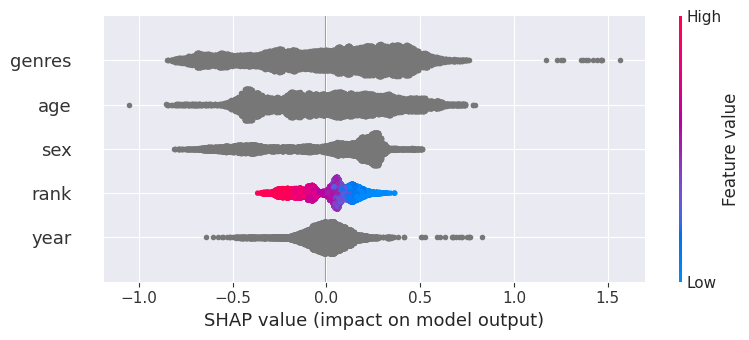

In [83]:
shap.summary_plot(explainer.shap_values(train_pool), features=np.hstack((catboost_train.num_feature_data,
                  catboost_train.cat_feature_data)), feature_names=catboost_train.get_feature_names())

In [84]:
del explainer

In [85]:
predicted_values = ranker.predict_proba(test_pool)[:, 1]
print("ROC AUC: ", roc_auc_score(test_pool.get_label(), predicted_values))
del predicted_values
del test_pool

ROC AUC:  0.6984379107525409


## Сравнение моделей

In [86]:
global_test = global_test.filter(pl.col("user_id").is_in(train_first_stage.get_column("user_id").unique()))

In [87]:
num_candidates = 200

In [88]:
first_stage_global_pred = first_stage_recommender.recommend(global_test, num_recs_per_user=num_candidates)

In [89]:
one_stage_model_metrics = compute_metrics(global_test, first_stage_global_pred, top_N, with_separate_k_col=True)

In [90]:
global_test_features = first_stage_global_pred.lazy().join(df_items_features.lazy(), on="item_id").join(df_users_features.lazy(), on="user_id").collect()

In [91]:
global_test_features.head(n=3)

user_id,item_id,rank,genres,year,age,sex
u32,u32,u32,str,str,str,str
16,121687,1,"""зарубежные дет…","""2007""","""45_54""","""0"""
16,209379,2,"""литература 20 …","""1910""","""45_54""","""0"""
16,251645,3,"""остросюжетные …","""2017""","""45_54""","""0"""


In [92]:
catboost_global_test = convert_to_features_data(global_test_features, exclude_columns)

In [93]:
predicted_proba = ranker.predict_proba(catboost_global_test)[:, 1]

In [94]:
del catboost_global_test

In [95]:
catboost_prediction = first_stage_global_pred.hstack(pl.DataFrame({"catboost_score": predicted_proba}, schema={"catboost_score": pl.Float32}))

In [96]:
catboost_prediction = catboost_prediction.sort(["user_id", "catboost_score"], descending=[False, True]).with_columns(
    pl.col("catboost_score").rank(method="ordinal", descending=True).over("user_id").alias("catboost_rank")
)

In [97]:
two_stage_model_metrics = compute_metrics(global_test, catboost_prediction.select(
    pl.col("user_id", "item_id"), pl.col("catboost_rank").alias("rank")), top_N, with_separate_k_col=True)


In [98]:
all_metrics = one_stage_model_metrics.with_columns(pl.lit("one_stage").alias("model")).vstack(
    two_stage_model_metrics.with_columns(pl.lit("two_stage").alias("model"))
)

In [99]:
all_metrics.head()

name,k,value,model
str,i64,f64,str
"""prec""",1,0.000263,"""one_stage"""
"""recall""",1,0.000263,"""one_stage"""
"""prec""",2,0.000329,"""one_stage"""
"""recall""",2,0.000329,"""one_stage"""
"""prec""",3,0.000307,"""one_stage"""


<Axes: xlabel='k', ylabel='value'>

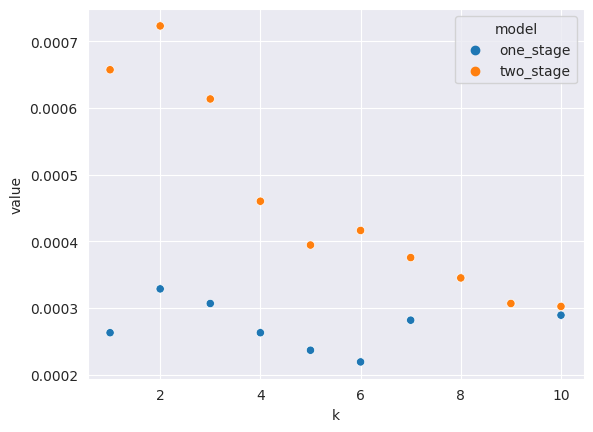

In [104]:
sns.scatterplot(all_metrics.filter(pl.col("name") == "prec"), x="k", y="value",  hue="model")

<Axes: xlabel='k', ylabel='value'>

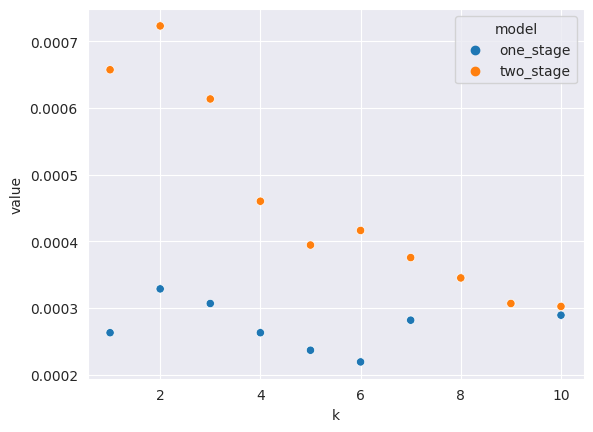

In [101]:
sns.scatterplot(all_metrics.filter(pl.col("name") == "recall"), x="k", y="value",  hue="model")

In [102]:
all_metrics.filter(pl.col("name").str.contains("MAP|MRR")).pivot(index="model", values="value", columns="name", aggregate_function="max")

model,MRR,MAP
str,f64,f64
"""one_stage""",0.281454,0.000494
"""two_stage""",0.477193,0.00065
